# VAE for Learning Representation

Code References:
- Data loading: https://discuss.pytorch.org/t/input-numpy-ndarray-instead-of-images-in-a-cnn/18797/3
- Train and test functions adapted from discussion sections code
- Following code from **Lab 08**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader

## Classify via logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
class VAE(nn.Module):
    def __init__(self, n_in, z_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(n_in, 1024) ## Encoder
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, z_dim*2) #(2 is for mu and variance)
        self.fc6 = nn.Linear(z_dim, 128) ## Decoder
        self.fc7 = nn.Linear(128, 256)
        self.fc8 = nn.Linear(256, 512)
        self.fc9 = nn.Linear(512, 1024)
        self.fc10 = nn.Linear(1024, n_in)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h1 = F.relu(self.fc2(h1))
        h1 = F.relu(self.fc3(h1))
        h1 = F.relu(self.fc4(h1))
        h2 = self.fc5(h1)
        return h2

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc6(z))
        h3 = F.relu(self.fc7(h3))
        h3 = F.relu(self.fc8(h3))
        h3 = F.relu(self.fc9(h3))
        return torch.sigmoid(self.fc10(h3))

    
    def sample(self, mu, var):
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat
    
    def forward(self, x):
        z_hat = self.encode(x)
        mu, logvar = torch.chunk(z_hat, 2, dim=1)
        if self.training:
            z = self.reparameterize(mu, logvar) ## always sample in training
        else: ## don't sample in test usually, use mean
            z = mu
        x_hat = self.decode(z)
        return x_hat, mu, logvar

In [3]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') ## sum all pixels to help with scale, don't normalize
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [4]:
def make_optimizer(optimizer_name, model, **kwargs):
    if optimizer_name=='Adam':
        optimizer = optim.Adam(model.parameters(),lr=kwargs['lr'])
    elif optimizer_name=='SGD':
        optimizer = optim.SGD(model.parameters(),lr=kwargs['lr'],momentum=kwargs['momentum'], weight_decay=kwargs['weight_decay'])
    else:
        raise ValueError('Not valid optimizer name')
    return optimizer
    
def make_scheduler(scheduler_name, optimizer, **kwargs):
    if scheduler_name=='MultiStepLR':
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=kwargs['milestones'],gamma=kwargs['factor'])
    else:
        raise ValueError('Not valid scheduler name')
    return scheduler

In [5]:
def train(model, device, train_loader, optimizer, epoch):
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(data.size(0),-1)
        data = data.to(device)
        optimizer.zero_grad()
        output, mu, logvar = model(data)
        loss = loss_function(output, data, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch_idx % (len(train_loader)//2) == 0:
            print('Train({})[{:.0f}%]: Loss: {:.4f}'.format(
                epoch, 100. * batch_idx / len(train_loader), train_loss/(batch_idx+1)))
    return

def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    batch_size = 32
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(data.size(0),-1)
            data = data.to(device)
            output, mu, logvar = model(data)
            loss = loss_function(output, data, mu, logvar)
            test_loss += loss.item() # sum up batch loss
    test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    print('Test({}): Loss: {:.4f}'.format(
        epoch, test_loss))
    return

In [6]:
# from https://discuss.pytorch.org/t/input-numpy-ndarray-instead-of-images-in-a-cnn/18797/3

class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

## Chromagrams

In [7]:
## Load data
train_chroma = np.load("Data/train_chroma12.npy")
test_chroma = np.load("Data/test_chroma12.npy")
train_labels = np.load("Data/train_labels_chroma12.npy")
test_labels = np.load("Data/test_labels_chroma12.npy")
train_chroma.shape

(5366, 12, 431)

In [8]:
bs = 32

train_set = MyDataset(train_chroma, train_labels)
train_loader = DataLoader(train_set, batch_size=bs, shuffle=True)
test_set = MyDataset(test_chroma, test_labels)
test_loader = DataLoader(test_set, batch_size=bs, shuffle=False)

In [20]:
seed = 1
device = 'cuda'
optimizer_name = 'Adam'
scheduler_name = 'MultiStepLR'
num_epochs = 100
lr = 0.001
torch.manual_seed(1)
device = torch.device(device)
torch.manual_seed(1)
torch.cuda.manual_seed(1)


n_in = train_chroma.shape[1]*train_chroma.shape[2]
z_dim = 40
vae = VAE(n_in, z_dim).to(device)
optimizer = make_optimizer(optimizer_name, vae, lr=lr, momentum=0, weight_decay=0)
scheduler = make_scheduler(scheduler_name, optimizer, milestones=[5], factor=0.1)
for epoch in range(1, num_epochs + 1):
    train(vae, device, train_loader, optimizer, epoch)
    test(vae, device, test_loader, epoch)
    scheduler.step()
    print('Optimizer Learning rate: {0:.4f}'.format(optimizer.param_groups[0]['lr']))

Train(1)[0%]: Loss: 114685.2109
Train(1)[50%]: Loss: -314409.2203
Test(1): Loss: -415386.3971
Optimizer Learning rate: 0.0010
Train(2)[0%]: Loss: -541213.9375
Train(2)[50%]: Loss: -507168.9279
Test(2): Loss: -623126.9362
Optimizer Learning rate: 0.0010
Train(3)[0%]: Loss: -688208.6250
Train(3)[50%]: Loss: -626941.9283
Test(3): Loss: -763196.8742
Optimizer Learning rate: 0.0010
Train(4)[0%]: Loss: -820571.0625
Train(4)[50%]: Loss: -745712.6691
Test(4): Loss: -825360.3378
Optimizer Learning rate: 0.0010
Train(5)[0%]: Loss: -875875.8125
Train(5)[50%]: Loss: -791553.2824
Test(5): Loss: -871359.1842
Optimizer Learning rate: 0.0001
Train(6)[0%]: Loss: -888208.1250
Train(6)[50%]: Loss: -868572.7654
Test(6): Loss: -888755.4915
Optimizer Learning rate: 0.0001
Train(7)[0%]: Loss: -885825.3750
Train(7)[50%]: Loss: -892876.1787
Test(7): Loss: -881656.6613
Optimizer Learning rate: 0.0001
Train(8)[0%]: Loss: -759669.0625
Train(8)[50%]: Loss: -884263.1018
Test(8): Loss: -876280.9268
Optimizer Learnin

### Plot Original Images

In [16]:
import librosa
import librosa.display

In [15]:
# ! pip install librosa

In [21]:
data,_ = next(iter(train_loader))
data_size = data.size()
data = data.view(data.size(0),-1).to(device)
output, mu, logvar = vae(data)
output = output.detach()

In [22]:
## Reshape
data = data.view(data_size)
print(data.shape)
output = output.view(data_size)
print(output.shape)

torch.Size([32, 12, 431])
torch.Size([32, 12, 431])


In [23]:
chroma_mean = 0.2806374888288301
chroma_sd = 0.29424393073518096

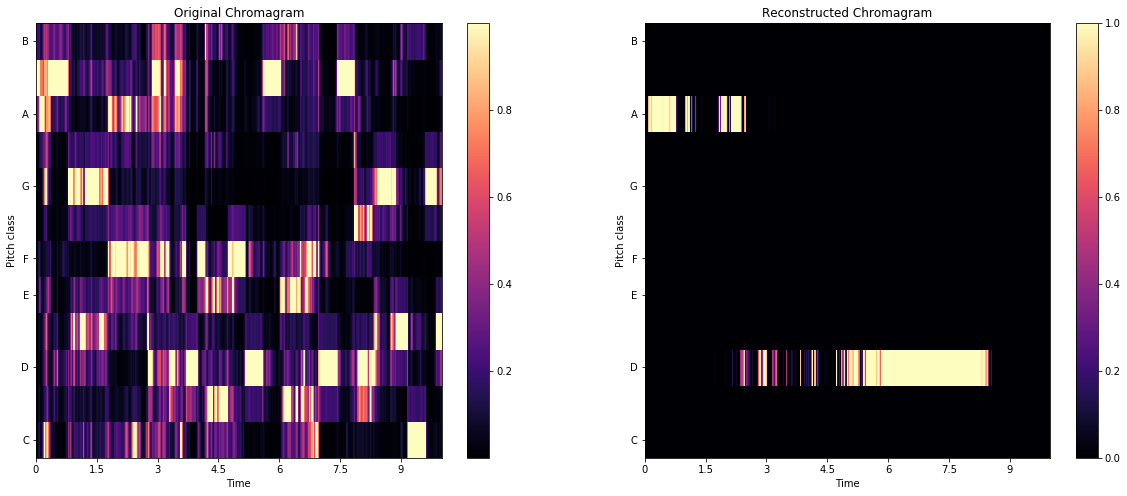

In [24]:
plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
librosa.display.specshow(chroma_sd*data[0,:,:].cpu().numpy() + chroma_mean, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title("Original Chromagram")
plt.subplot(1,2,2)
librosa.display.specshow(output[0,:,:].cpu().numpy(), y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title("Reconstructed Chromagram")
pass

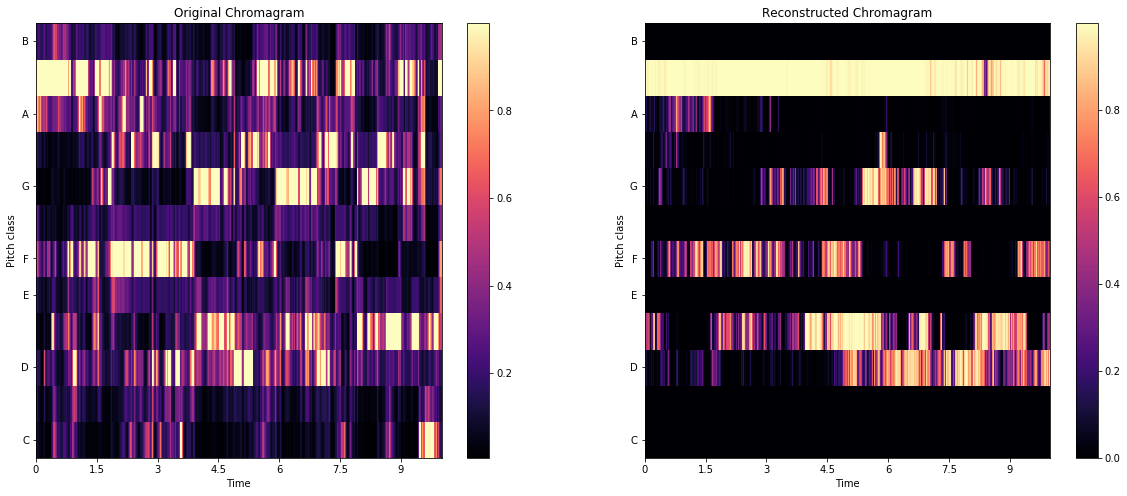

In [25]:
plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
librosa.display.specshow(chroma_sd*data[17,:,:].cpu().numpy() + chroma_mean, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title("Original Chromagram")
plt.subplot(1,2,2)
librosa.display.specshow(output[17,:,:].cpu().numpy(), y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title("Reconstructed Chromagram")
pass

### Extract Features for Classification

- use learned mu and variance for classification

In [26]:
mu.shape

torch.Size([32, 40])

In [27]:
logvar.shape

torch.Size([32, 40])

In [28]:
torch.cat((mu, logvar),1).shape

torch.Size([32, 80])

In [29]:
VAE_train_features = torch.zeros(1, z_dim*2).to(device)

for batch_idx, (data, target) in enumerate(train_loader):
    data = data.view(data.shape[0], data.shape[1]*data.shape[2])
    img = data.to(device)
    output, mu, logvar = vae(img)
    enc_output = torch.cat((mu, logvar),1)
    VAE_train_features = torch.cat((VAE_train_features, enc_output), 0)
#     print(VAE_train_features.size())
    if batch_idx == 0:
        VAE_train_labels = target
    else:
        VAE_train_labels = torch.cat((VAE_train_labels, target), 0)

In [30]:
VAE_test_features = torch.zeros(1, z_dim*2).to(device)

for batch_idx, (data, target) in enumerate(test_loader):
    data = data.view(data.shape[0], data.shape[1]*data.shape[2])
    img = data.to(device)
    output, mu, logvar = vae(img)
    enc_output = torch.cat((mu, logvar),1)
    VAE_test_features = torch.cat((VAE_test_features, enc_output), 0)
    
    if batch_idx == 0:
        VAE_test_labels = target
    else:
        VAE_test_labels = torch.cat((VAE_test_labels, target), 0)

In [31]:
VAE_train_features.size()

torch.Size([5367, 80])

In [32]:
VAE_test_features.size()

torch.Size([3843, 80])

In [33]:
VAE_train_features = VAE_train_features[1:, :].cpu().detach().numpy()
VAE_test_features = VAE_test_features[1:, :].cpu().detach().numpy()

In [34]:
## Classify via logistic regression
clf = LogisticRegression(multi_class='multinomial', solver='saga',
                        max_iter = 5000).fit(X=VAE_train_features, y=VAE_train_labels)

In [35]:
## Training Accuracy
y_pred = clf.predict(VAE_train_features)
VAE_train_acc = metrics.accuracy_score(VAE_train_labels, y_pred)
VAE_train_acc

0.43346999627282895

In [36]:
## Test Accuracy
y_pred = clf.predict(VAE_test_features)
VAE_test_acc = metrics.accuracy_score(VAE_test_labels, y_pred)
VAE_test_acc

0.3872982821447163

## MFCC - 13

In [7]:
## Load data
train_mfcc = np.load("Data/train_mfcc13.npy")
test_mfcc = np.load("Data/test_mfcc13.npy")
train_labels = np.load("Data/train_labels_mfcc13.npy")
test_labels = np.load("Data/test_labels_mfcc13.npy")

In [8]:
bs = 32

train_set_mfcc = MyDataset(train_mfcc, train_labels)
train_loader_mfcc = DataLoader(train_set_mfcc, batch_size=bs, shuffle=True)
test_set_mfcc = MyDataset(test_mfcc, test_labels)
test_loader_mfcc = DataLoader(test_set_mfcc, batch_size=bs, shuffle=False)

In [9]:
mean_mfcc = -15.351313770438622
std_mfcc = 104.4164497835367

In [10]:
device = 'cuda'
optimizer_name = 'Adam'
scheduler_name = 'MultiStepLR'
num_epochs = 100
lr = 0.001

device = torch.device(device)

n_in = train_mfcc.shape[1]*train_mfcc.shape[2]
z_dim = 40
vae = VAE(n_in, z_dim).to(device)
optimizer = make_optimizer(optimizer_name, vae, lr=lr, momentum=0, weight_decay=0)
scheduler = make_scheduler(scheduler_name, optimizer, milestones=[5], factor=0.1)
for epoch in range(1, num_epochs + 1):
    train(vae, device, train_loader_mfcc, optimizer, epoch)
    test(vae, device, test_loader_mfcc, epoch)
    scheduler.step()
    print('Optimizer Learning rate: {0:.4f}'.format(optimizer.param_groups[0]['lr']))

Train(1)[0%]: Loss: 124257.2422
Train(1)[50%]: Loss: -1752493.0975
Test(1): Loss: -983258.6226
Optimizer Learning rate: 0.0010
Train(2)[0%]: Loss: -2298925.5000
Train(2)[50%]: Loss: -1958254.9662
Test(2): Loss: -1067725.4446
Optimizer Learning rate: 0.0010
Train(3)[0%]: Loss: -2032775.5000
Train(3)[50%]: Loss: -2070817.5794
Test(3): Loss: -1204240.4073
Optimizer Learning rate: 0.0010
Train(4)[0%]: Loss: -1874914.1250
Train(4)[50%]: Loss: -1842331.8147
Test(4): Loss: -1686731.7941
Optimizer Learning rate: 0.0010
Train(5)[0%]: Loss: -2655689.2500
Train(5)[50%]: Loss: -2067290.9956
Test(5): Loss: -1487743.8637
Optimizer Learning rate: 0.0001
Train(6)[0%]: Loss: -1803459.3750
Train(6)[50%]: Loss: -1778340.2941
Test(6): Loss: -1564624.4099
Optimizer Learning rate: 0.0001
Train(7)[0%]: Loss: -1788362.7500
Train(7)[50%]: Loss: -1859943.6294
Test(7): Loss: -1582469.0480
Optimizer Learning rate: 0.0001
Train(8)[0%]: Loss: -1813730.2500
Train(8)[50%]: Loss: -1913578.5397
Test(8): Loss: -1575706.

In [11]:
data,_ = next(iter(train_loader_mfcc))
data_size = data.size()
data = data.view(data.size(0),-1).to(device)
output, mu, logvar = vae(data)
output = output.detach()

In [12]:
## Reshape
data = data.view(data_size)
print(data.shape)
output = output.view(data_size)
print(output.shape)

torch.Size([32, 13, 431])
torch.Size([32, 13, 431])


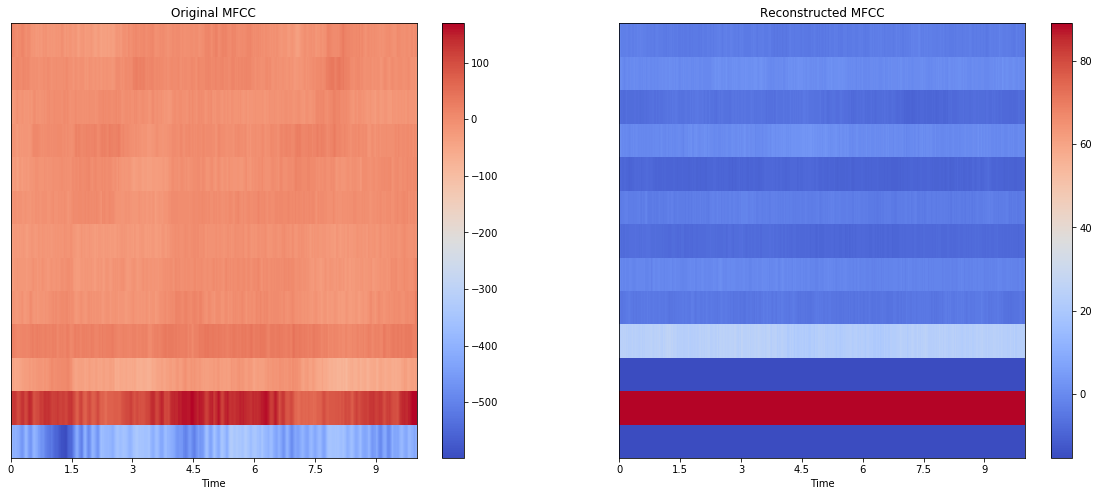

In [20]:
plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
librosa.display.specshow(std_mfcc*data[0,:,:].cpu().numpy() + mean_mfcc,  x_axis='time')
plt.colorbar()
plt.title("Original MFCC")
plt.subplot(1,2,2)
librosa.display.specshow(std_mfcc*output[0,:,:].cpu().numpy()+mean_mfcc,  x_axis='time')
plt.colorbar()
plt.title("Reconstructed MFCC")
pass

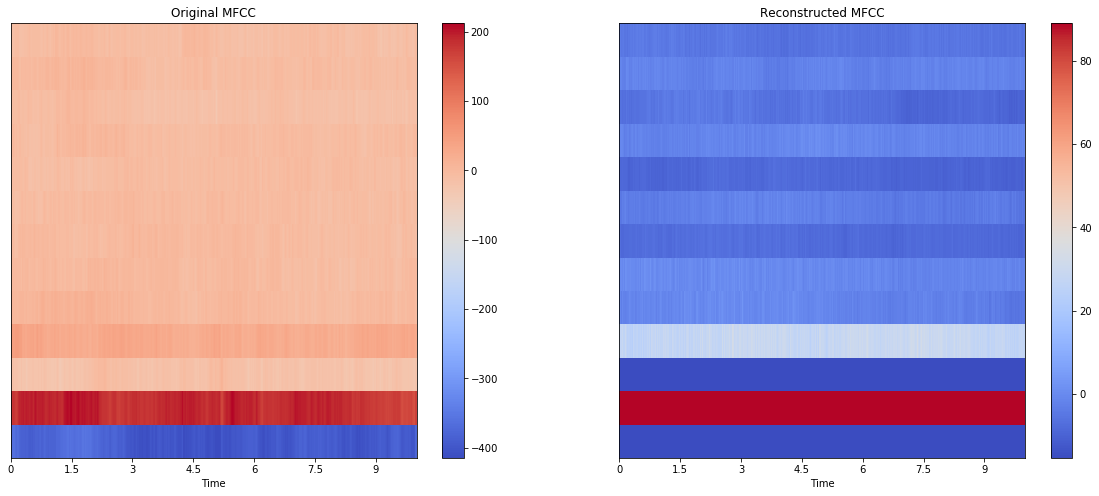

In [18]:
plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
librosa.display.specshow(std_mfcc*data[17,:,:].cpu().numpy() + mean_mfcc,  x_axis='time')
plt.colorbar()
plt.title("Original MFCC")
plt.subplot(1,2,2)
librosa.display.specshow(std_mfcc*output[17,:,:].cpu().numpy() + mean_mfcc,  x_axis='time')
plt.colorbar()
plt.title("Reconstructed MFCC")
pass

In [21]:
## Convert features for classification


VAE_train_features = torch.zeros(1, z_dim*2).to(device)

for batch_idx, (data, target) in enumerate(train_loader_mfcc):
    data = data.view(data.shape[0], data.shape[1]*data.shape[2])
    img = data.to(device)
    output, mu, logvar = vae(img)
    enc_output = torch.cat((mu, logvar),1)
    VAE_train_features = torch.cat((VAE_train_features, enc_output), 0)
#     print(VAE_train_features.size())
    if batch_idx == 0:
        VAE_train_labels = target
    else:
        VAE_train_labels = torch.cat((VAE_train_labels, target), 0)

In [22]:
VAE_test_features = torch.zeros(1, z_dim*2).to(device)

for batch_idx, (data, target) in enumerate(test_loader_mfcc):
    data = data.view(data.shape[0], data.shape[1]*data.shape[2])
    img = data.to(device)
    output, mu, logvar = vae(img)
    enc_output = torch.cat((mu, logvar),1)
    VAE_test_features = torch.cat((VAE_test_features, enc_output), 0)
    
    if batch_idx == 0:
        VAE_test_labels = target
    else:
        VAE_test_labels = torch.cat((VAE_test_labels, target), 0)

In [23]:
VAE_train_features = VAE_train_features[1:, :].cpu().detach().numpy()
VAE_test_features = VAE_test_features[1:, :].cpu().detach().numpy()

In [24]:
## Classify via logistic regression
clf = LogisticRegression(multi_class='multinomial', solver='saga',
                        max_iter = 5000).fit(X=VAE_train_features, y=VAE_train_labels)

In [25]:
## Training Accuracy
y_pred = clf.predict(VAE_train_features)
VAE_train_acc = metrics.accuracy_score(VAE_train_labels, y_pred)
VAE_train_acc

0.4787551248602311

In [26]:
## Test Accuracy
y_pred = clf.predict(VAE_test_features)
VAE_test_acc = metrics.accuracy_score(VAE_test_labels, y_pred)
VAE_test_acc

0.45445080687142114

## STFT

In [27]:
## Load data

train_stft1 = np.load("Data/train_stft-dB-1.npy", allow_pickle = True)
test_stft1 = np.load("Data/test_stft-dB-1.npy")
train_labels1 = np.load("Data/train_labels_stft-dB-1.npy")
test_labels1 = np.load("Data/test_labels_stft-dB-1.npy")

## Load new data
train_stft2 = np.load("Data/train_stft-dB-2.npy", allow_pickle = True)
test_stft2 = np.load("Data/test_stft-dB-2.npy")
train_labels2 = np.load("Data/train_labels_stft-dB-2.npy")
test_labels2 = np.load("Data/test_labels_stft-dB-2.npy")


In [28]:
train_stft = np.concatenate((train_stft1, train_stft2))
test_stft = np.concatenate((test_stft1, test_stft2))
train_labels = np.concatenate((train_labels1, train_labels2))
test_labels = np.concatenate((test_labels1, test_labels2))

In [29]:
bs = 32

train_set = MyDataset(train_stft, train_labels)
train_loader = DataLoader(train_set, batch_size=bs, shuffle=True)
test_set = MyDataset(test_stft, test_labels)
test_loader = DataLoader(test_set, batch_size=bs, shuffle=False)

In [30]:
mean_stft = -39.25553443598964
std_stft = 16.763774999817553

In [31]:
device = 'cuda'
optimizer_name = 'Adam'
scheduler_name = 'MultiStepLR'
num_epochs = 100
lr = 0.001

device = torch.device(device)

n_in = train_stft.shape[1]*train_stft.shape[2]
z_dim = 40
vae = VAE(n_in, z_dim).to(device)
optimizer = make_optimizer(optimizer_name, vae, lr=lr, momentum=0, weight_decay=0)
scheduler = make_scheduler(scheduler_name, optimizer, milestones=[5], factor=0.1)
for epoch in range(1, num_epochs + 1):
    train(vae, device, train_loader, optimizer, epoch)
    test(vae, device, test_loader, epoch)
    scheduler.step()
    print('Optimizer Learning rate: {0:.4f}'.format(optimizer.param_groups[0]['lr']))

Train(1)[0%]: Loss: 612054.3125
Train(1)[50%]: Loss: 11618392523.2526
Test(1): Loss: -7285644.1193
Optimizer Learning rate: 0.0010
Train(2)[0%]: Loss: -9103925.0000
Train(2)[50%]: Loss: -9918074.6429
Test(2): Loss: -12361067.4889
Optimizer Learning rate: 0.0010
Train(3)[0%]: Loss: -10846649.0000
Train(3)[50%]: Loss: -11452878.2571
Test(3): Loss: -11350264.8062
Optimizer Learning rate: 0.0010
Train(4)[0%]: Loss: -11292721.0000
Train(4)[50%]: Loss: -11609351.3143
Test(4): Loss: -11055281.2003
Optimizer Learning rate: 0.0010
Train(5)[0%]: Loss: -10066994.0000
Train(5)[50%]: Loss: -11367601.8286
Test(5): Loss: -11442840.3251
Optimizer Learning rate: 0.0001
Train(6)[0%]: Loss: -12596298.0000
Train(6)[50%]: Loss: -11565652.2571
Test(6): Loss: -11115724.6073
Optimizer Learning rate: 0.0001
Train(7)[0%]: Loss: -11005439.0000
Train(7)[50%]: Loss: -11306241.7429
Test(7): Loss: -11123739.3771
Optimizer Learning rate: 0.0001
Train(8)[0%]: Loss: -12302415.0000
Train(8)[50%]: Loss: -11523068.2857
Te

In [32]:
## Load new data
train_stft1 = np.load("Data/train_stft-dB-3.npy", allow_pickle = True)
test_stft1 = np.load("Data/test_stft-dB-3.npy")
train_labels1 = np.load("Data/train_labels_stft-dB-3.npy")
test_labels1 = np.load("Data/test_labels_stft-dB-3.npy")

train_stft2 = np.load("Data/train_stft-dB-4.npy", allow_pickle = True)
test_stft2 = np.load("Data/test_stft-dB-4.npy")
train_labels2 = np.load("Data/train_labels_stft-dB-4.npy")
test_labels2 = np.load("Data/test_labels_stft-dB-4.npy")

train_stft = np.concatenate((train_stft1, train_stft2))
test_stft = np.concatenate((test_stft1, test_stft2))
train_labels = np.concatenate((train_labels1, train_labels2))
test_labels = np.concatenate((test_labels1, test_labels2))

bs = 32

train_set = MyDataset(train_stft, train_labels)
train_loader = DataLoader(train_set, batch_size=bs, shuffle=True)
test_set = MyDataset(test_stft, test_labels)
test_loader = DataLoader(test_set, batch_size=bs, shuffle=False)

In [33]:
for epoch in range(1, num_epochs + 1):
    train(vae, device, train_loader, optimizer, epoch)
    test(vae, device, test_loader, epoch)
    scheduler.step()
    print('Optimizer Learning rate: {0:.4f}'.format(optimizer.param_groups[0]['lr']))

Train(1)[0%]: Loss: -8457025.0000
Train(1)[50%]: Loss: -9819045.0286
Test(1): Loss: -10427640.4167
Optimizer Learning rate: 0.0001
Train(2)[0%]: Loss: -9138448.0000
Train(2)[50%]: Loss: -10002808.0143
Test(2): Loss: -10447198.5417
Optimizer Learning rate: 0.0001
Train(3)[0%]: Loss: -9180302.0000
Train(3)[50%]: Loss: -10111565.2571
Test(3): Loss: -10505741.2917
Optimizer Learning rate: 0.0001
Train(4)[0%]: Loss: -10687079.0000
Train(4)[50%]: Loss: -10241559.8286
Test(4): Loss: -10419030.5833
Optimizer Learning rate: 0.0001
Train(5)[0%]: Loss: -10176617.0000
Train(5)[50%]: Loss: -10128493.6000
Test(5): Loss: -10311602.2188
Optimizer Learning rate: 0.0001
Train(6)[0%]: Loss: -9282756.0000
Train(6)[50%]: Loss: -10064097.9714
Test(6): Loss: -10446656.6042
Optimizer Learning rate: 0.0001
Train(7)[0%]: Loss: -11123976.0000
Train(7)[50%]: Loss: -10159185.7143
Test(7): Loss: -10364037.2708
Optimizer Learning rate: 0.0001
Train(8)[0%]: Loss: -10451258.0000
Train(8)[50%]: Loss: -10262489.0286
Tes

In [34]:
## Load new data
train_stft = np.load("Data/train_stft-dB-5.npy", allow_pickle = True)
test_stft = np.load("Data/test_stft-dB-5.npy")
train_labels = np.load("Data/train_labels_stft-dB-5.npy")
test_labels = np.load("Data/test_labels_stft-dB-5.npy")


bs = 32

train_set = MyDataset(train_stft, train_labels)
train_loader = DataLoader(train_set, batch_size=bs, shuffle=True)
test_set = MyDataset(test_stft, test_labels)
test_loader = DataLoader(test_set, batch_size=bs, shuffle=False)

In [35]:
for epoch in range(1, num_epochs + 1):
    train(vae, device, train_loader, optimizer, epoch)
    test(vae, device, test_loader, epoch)
    scheduler.step()
    print('Optimizer Learning rate: {0:.4f}'.format(optimizer.param_groups[0]['lr']))

Train(1)[0%]: Loss: -8685139.0000
Train(1)[50%]: Loss: -10029354.1389
Test(1): Loss: -10475588.5417
Optimizer Learning rate: 0.0001
Train(2)[0%]: Loss: -9922790.0000
Train(2)[50%]: Loss: -10124958.4444
Test(2): Loss: -10474766.3333
Optimizer Learning rate: 0.0001
Train(3)[0%]: Loss: -10165093.0000
Train(3)[50%]: Loss: -10369003.6667
Test(3): Loss: -10547048.7083
Optimizer Learning rate: 0.0001
Train(4)[0%]: Loss: -8814124.0000
Train(4)[50%]: Loss: -10058890.9444
Test(4): Loss: -10581571.9167
Optimizer Learning rate: 0.0001
Train(5)[0%]: Loss: -10870977.0000
Train(5)[50%]: Loss: -10070074.1111
Test(5): Loss: -10538551.4583
Optimizer Learning rate: 0.0001
Train(6)[0%]: Loss: -9983216.0000
Train(6)[50%]: Loss: -10356963.9444
Test(6): Loss: -10481671.1250
Optimizer Learning rate: 0.0001
Train(7)[0%]: Loss: -9655808.0000
Train(7)[50%]: Loss: -10282167.5556
Test(7): Loss: -10586136.2083
Optimizer Learning rate: 0.0001
Train(8)[0%]: Loss: -9929916.0000
Train(8)[50%]: Loss: -10128554.5556
Test

In [39]:
data,_ = next(iter(train_loader))
data_size = data.size()
data = data.view(data.size(0),-1).to(device)
output, mu, logvar = vae(data)
output = output.detach()

In [40]:
## Reshape
data = data.view(data_size)
print(data.shape)
output = output.view(data_size)
print(output.shape)
sr = 22050

torch.Size([32, 64, 431])
torch.Size([32, 64, 431])


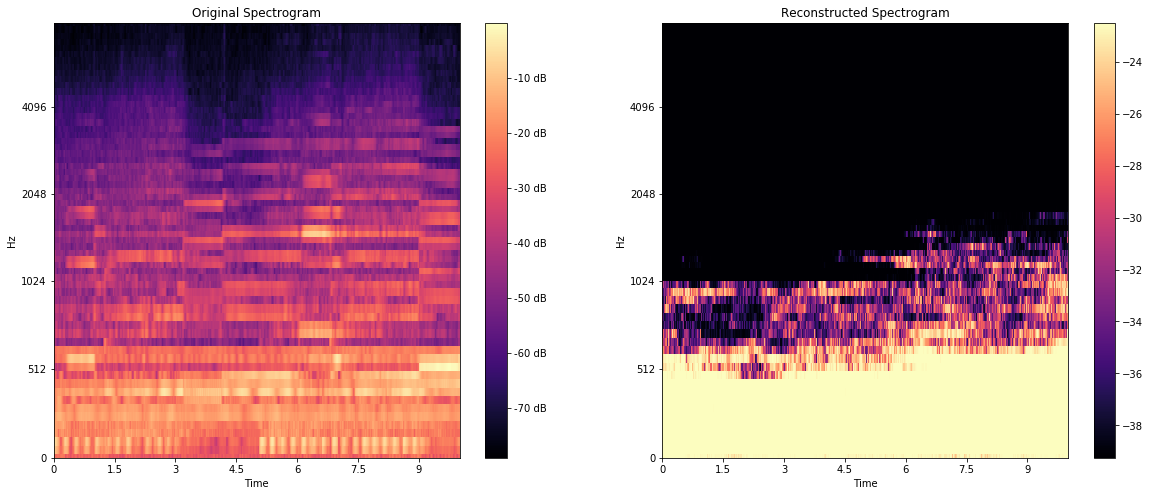

In [42]:
plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
librosa.display.specshow(std_stft*data[0,:,:].cpu().numpy() + mean_stft, x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("Original Spectrogram")
plt.subplot(1,2,2)
librosa.display.specshow(std_stft*output[0,:,:].cpu().numpy() + mean_stft, x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar()
plt.title("Reconstructed Spectrogram")
pass

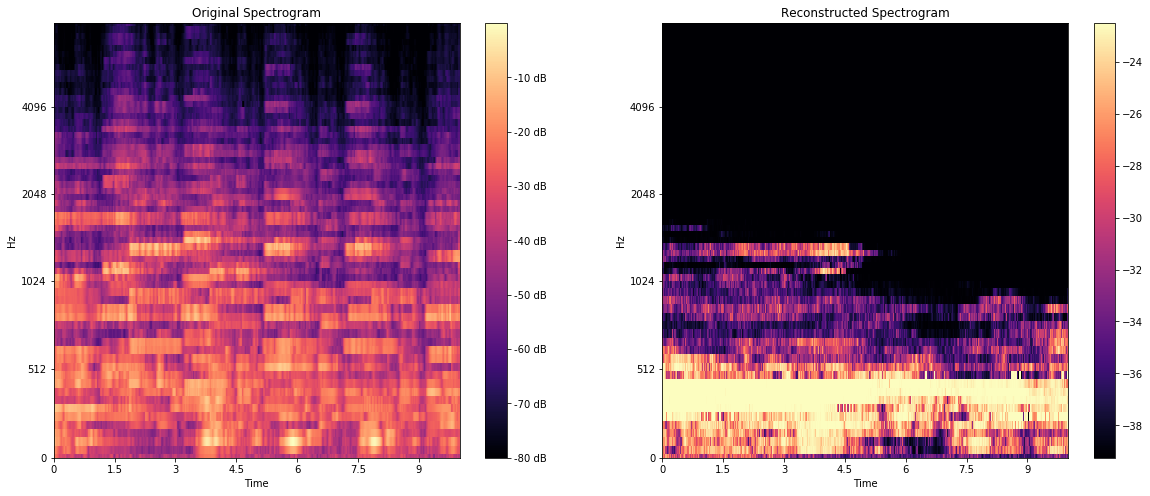

In [43]:
plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
librosa.display.specshow(std_stft*data[17,:,:].cpu().numpy() + mean_stft, x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("Original Spectrogram")
plt.subplot(1,2,2)
librosa.display.specshow(std_stft*output[17,:,:].cpu().numpy() + mean_stft, x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar()
plt.title("Reconstructed Spectrogram")
pass

In [44]:
## Convert features for classification


VAE_train_features = torch.zeros(1, z_dim*2).to(device)

for batch_idx, (data, target) in enumerate(train_loader):
    data = data.view(data.shape[0], data.shape[1]*data.shape[2])
    img = data.to(device)
    output, mu, logvar = vae(img)
    enc_output = torch.cat((mu, logvar),1)
    VAE_train_features = torch.cat((VAE_train_features, enc_output), 0)
#     print(VAE_train_features.size())
    if batch_idx == 0:
        VAE_train_labels = target
    else:
        VAE_train_labels = torch.cat((VAE_train_labels, target), 0)

In [45]:
VAE_test_features = torch.zeros(1, z_dim*2).to(device)

for batch_idx, (data, target) in enumerate(test_loader):
    data = data.view(data.shape[0], data.shape[1]*data.shape[2])
    img = data.to(device)
    output, mu, logvar = vae(img)
    enc_output = torch.cat((mu, logvar),1)
    VAE_test_features = torch.cat((VAE_test_features, enc_output), 0)
    
    if batch_idx == 0:
        VAE_test_labels = target
    else:
        VAE_test_labels = torch.cat((VAE_test_labels, target), 0)

In [46]:
VAE_train_features = VAE_train_features[1:, :].cpu().detach().numpy()
VAE_test_features = VAE_test_features[1:, :].cpu().detach().numpy()

In [47]:
## Classify via logistic regression
clf = LogisticRegression(multi_class='multinomial', solver='saga',
                        max_iter = 5000).fit(X=VAE_train_features, y=VAE_train_labels)

In [48]:
## Training Accuracy
y_pred = clf.predict(VAE_train_features)
VAE_train_acc = metrics.accuracy_score(VAE_train_labels, y_pred)
VAE_train_acc

0.4678471575023299

In [49]:
## Test Accuracy
y_pred = clf.predict(VAE_test_features)
VAE_test_acc = metrics.accuracy_score(VAE_test_labels, y_pred)
VAE_test_acc

0.3684895833333333